# DS 3000 HW 1

Due: Tuesday May 20 @ 11:59 PM EST

### Submission Instructions
Upload this `ipynb` file to GitHub, and then to Gradescope.  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to GitHub and verify that the correct version is represented on Gradescope.

### Tips for success
- Start early
- Make use of Slack
- Remember to use cells, headings and markdown to make the notebook easy to read (if I can't find the answer to a problem, you will receive no points for it)
- Collaborate: bounce ideas off of each other, if you are having trouble you can ask your classmates or Dr. Gerber for help with specific issues, however...
- [(See)](http://www.northeastern.edu/osccr/academic-integrity), i.e. you are welcome to **talk about/discuss** (*not* show or allow each other to copy your answers to) the problems.

# Part 1: Sunrise-Sunset API

This first part of the homework asks you to complete the pipeline which, given the lattitude / longitude and timezone of some cities; Boston (where we usually are), Leuven (where we actually are), and Sydney (where the other Khoury Dialogue is):

``` python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Leuven': (50.8823, 4.7138, 'Europe/Brussels'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
```

the keys are the `name` of the city and the values are tuples of `lat`, `lon`, `timezone_name`

is able to:
- query a sunrise / sunset API
- clean and process data (timezone management & building `datetime` objects)
- produce the a graph of daylight through the year like this:

<img src="https://i.ibb.co/BVVSs51J/hw1-image.png" alt="hw1-image" style="width: 500px;"/>

## Part 1.1: Getting Sunrise Sunset via API (20 points)
Write the `get_sunrise_sunset()` function below so that it uses [this sunrise sunset API](https://sunrise-sunset.org/api) to produce the output (the dictionary) shown in the test case below so that it passes the case.

It may be helpful to know that this particular API...
- requires no api key
- returns about 2.5 queries per second
- did not block me when I tried to make 100 consecutive calls as quickly as possible

In [2]:
# make sure you have these modules installed
import requests
import json

In [3]:
# make sure to write a good docstring! I will do this for you for the other functions in this homework, but you should practice here!
def get_sunrise_sunset(lat, lng, date):
    '''
    Retreives the sunrise and sunset data from an API
    lat: a float that describes latitude coordinates
    long: a float that describes longitude coordinates
    date: a string that describes the date in yyyy/mm/dd
    returns a dictionary of the API data
    '''
    
    api_url = f"https://api.sunrise-sunset.org/json?lat={lat}&lng={lng}&date={date}"

    data = requests.get(api_url)
    data_dict = json.loads(data.text)
    data_dict['lat-lng'] = (lat, lng)
    data_dict['date'] = date
    
    return data_dict






In [4]:
sun_dict = get_sunrise_sunset(lat=50.8823, lng=4.7138, date='2025-05-20')
# Note; I ran this and created this sun_dict_expected on May 9th
# It is possible some of the results have changed since then
# If the print(sun_dict) looks very close to the sun_dict_expected below
# Let me know and I'll verify whether I need to change something
sun_dict_expected = \
{'results': {'sunrise': '3:42:26 AM',
  'sunset': '7:32:59 PM',
  'solar_noon': '11:37:42 AM',
  'day_length': '15:50:33',
  'civil_twilight_begin': '3:02:38 AM',
  'civil_twilight_end': '8:12:46 PM',
  'nautical_twilight_begin': '2:04:57 AM',
  'nautical_twilight_end': '9:10:28 PM',
  'astronomical_twilight_begin': '12:32:47 AM',
  'astronomical_twilight_end': '10:42:37 PM'},
 'status': 'OK',
 'tzid': 'UTC',
 'lat-lng': (50.8823, 4.7138),
 'date': '2025-05-20'}




assert sun_dict == sun_dict_expected



## Part 1.2 Timezone Considerations: (20 points)

It may appear the test case above works, but a look at the API's documentation reminds us: 

    "NOTE: All times are in UTC and summer time adjustments are not included in the returned data."
    
Meaning that we would need to change the timezone ourself if comparing different locations. 

Complete the `change_tz()` below so that it passes the given test case. You may want to investigate the [.astimezone function](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.astimezone.html).

In [5]:
# you will need these
import pytz
from datetime import datetime

In [6]:
# I have started the function for you
def change_tz(dt, timezone_from, timezone_to):
    """ converts timezone of a timezone naive datetime object
    
    Args:
        dt (datetime): datetime (or time) object without timezone
        timezone_from (str): timezone of input
        timezone_to (str): timezone of output datetime
        
    Returns:
        dt (datetime): datetime object corresponding to 
            unix_time
    """
    
  
    tz_from = pytz.timezone(timezone_from)
    tz_to = pytz.timezone(timezone_to)
    dt_from_aware = tz_from.localize(dt)
    dt_to = dt_from_aware.astimezone(tz_to)
    

    return dt_to


In [7]:
# build test case input / output 
#Brussels time
dt_no_tz = datetime(2025, 8, 15, 16, 23, 42, 270088)
#Converted to GMT should be two hours less (during August, due to daylight savings)
dt_expect = datetime(2025, 8, 15, 14, 23, 42, 270088, tzinfo=pytz.timezone('GMT')) 


# compute actual output
dt = change_tz(dt_no_tz, timezone_from='Europe/Brussels', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'
dt_expect

datetime.datetime(2025, 8, 15, 14, 23, 42, 270088, tzinfo=<StaticTzInfo 'GMT'>)

## Part 1.3: Turning the dictionary into a Series (20 points)
Build `clean_sun_dict()` to pass each of the two test cases below.  Note that:
- sunrise and sunset are `time` objects which account for daylight's saving:
    - include the date when building these objects
    - use `change_tz()` above to cast them to the proper timezone
    - build `time` objects by calling `datetime.time()` to discard the date of a `datetime`
    - importing `pandas as pd` and using `pd.to_datetime` may also be helpful
- `sunrise_hr` and `sunset_hr` are the hours since the day began in local timezone (more easily graphed)
    - you may use `.strftime()` and `int()` to cast time objects to strings and then integers (which may be helpful) 
    
**NOTE:** There may be more than one way to accomplish writing this function; as long as the function passes both `assert` test cases, you may continue. Just do be sure to comment and present your code as cleanly as possible. **NOTE ALSO** that because of the way *I* made the solution, the `sunrise_hr` and `sunset_hr` values are rounded strangely. If you are getting something *close*, you **may** change the test case to match your so that the `assert` works.

In [8]:
from datetime import datetime, time
import pandas as pd
from pandas import testing as tm

In [9]:
def clean_sun_dict(sun_dict, timezone_to):
    """ builds pandas series and cleans output of API
    
    Args:
        sun_dict (dict): dict of json (see ex below)
        timezone_to (str): timezone of outputs (API returns
            UTC times)
            
    Returns:
        sun_series (pd.Series): all times converted to
            time objects
    
    example sun_series:
    
    date            2021-02-13 00:00:00
    lat-lng        (36.72016, -4.42034)
    sunrise                    02:11:06
    sunrise_hr                    2.185
    sunset                     13:00:34
    sunset_hr                   13.0094
    dtype: object
    """
    series_dict = {}
    date = sun_dict['date']
    dateObj = datetime.strptime(date, '%Y-%m-%d').date()
    series_dict['date'] = datetime.strptime(date, '%Y-%m-%d')
    series_dict['lat-lng'] = sun_dict['lat-lng']
    sunrise_dt = datetime.strptime(sun_dict['results']['sunrise'], '%I:%M:%S %p')
    sunrise = datetime.combine(dateObj,time(hour=sunrise_dt.hour, minute=sunrise_dt.minute, second=sunrise_dt.second))
    converted_tz = change_tz(sunrise,'UTC', timezone_to)
    series_dict['sunrise'] = converted_tz.time()
    series_dict['sunrise_hr'] = round(converted_tz.hour + converted_tz.minute/60 + converted_tz.second/3600,6)
    
    sunset_dt = datetime.strptime(sun_dict['results']['sunset'], '%I:%M:%S %p')
    sunset = datetime.combine(dateObj,time(hour=sunset_dt.hour, minute=sunset_dt.minute, second=sunset_dt.second))
    
    converted_tz_2 = change_tz(sunset,'UTC', timezone_to)
    series_dict['sunset'] = converted_tz_2.time()
    series_dict['sunset_hr'] = round(converted_tz_2.hour + converted_tz_2.minute/60 + converted_tz_2.second/3600,6)
    
   
    return pd.Series(series_dict)
    


    
    # Function content here, remove pass below


In [10]:
sun_dict = {'results': {'sunrise': '3:42:26 AM',
  'sunset': '7:32:59 PM',
  'solar_noon': '11:37:42 AM',
  'day_length': '15:50:33',
  'civil_twilight_begin': '3:02:38 AM',
  'civil_twilight_end': '8:12:46 PM',
  'nautical_twilight_begin': '2:04:57 AM',
  'nautical_twilight_end': '9:10:28 PM',
  'astronomical_twilight_begin': '12:32:47 AM',
  'astronomical_twilight_end': '10:42:37 PM'},
 'status': 'OK',
 'tzid': 'UTC',
 'lat-lng': (50.8823, 4.7138),
 'date': '2025-05-20'}

# test without timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='GMT')

sun_series_exp = pd.Series(
{'date': datetime(year=2025, month=5, day=20),
'lat-lng': (50.8823, 4.7138),
'sunrise': time(hour=3, minute=42, second=26),
'sunrise_hr': 3.707222,
'sunset': time(hour=19, minute=32, second=59),
'sunset_hr': 19.549722})



tm.assert_series_equal(sun_series, sun_series_exp)




In [11]:
# test with timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='Europe/Brussels',)

sun_series_exp = pd.Series(
{'date': datetime(year=2025, month=5, day=20),
'lat-lng': (50.8823, 4.7138),
'sunrise': time(hour=5, minute=42, second=26),
'sunrise_hr': 5.707222,
'sunset': time(hour=21, minute=32, second=59),
'sunset_hr': 21.549722})

tm.assert_series_equal(sun_series, sun_series_exp)




## Part 1.4: Getting our Data Frame (20 points)

Write the `get_annual_sun_data()` function so that it produces the outputs shown below.  This function should make use of:
 - `get_sunrise_sunset()`
 - `clean_sun_dict()`
   
as built above. I will start the function for you to help!

For example, the following snippet (I left it as 2021, but you'll do 2024):

```python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Leuven': (50.8823, 4.7138, 'Europe/Brussels'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)
df_annual_sun.head(6)
```

should generate:

|    |   city |       date |              lat-lng |  sunrise | sunrise_hr |   sunset | sunset_hr |
|---:|-------:|-----------:|---------------------:|---------:|-----------:|---------:|----------:|
|  0 | Boston | 2021-01-01 |  (42.3601, -71.0589) | 07:11:49 |   7.196944 | 16:24:12 | 16.403333 |
|  1 | Leuven | 2021-01-01 |  (50.8823, 4.7138)   | 08:41:35 |   8.693056 | 16:48:03 | 16.800833 |
|  2 | Sydney | 2021-01-01 | (-33.8688, 151.2093) | 05:46:24 |   5.773333 | 20:10:53 | 20.181389 |
|  3 | Boston | 2021-01-31 |  (42.3601, -71.0589) | 06:56:43 |   6.945278 | 16:58:42 | 16.978333 |

|  4 | Leuven | 2021-01-31 |  (50.8823, 4.7138)   | 08:16:27 |   8.274167 | 17:32:44 | 17.545556 |
|  5 | Sydney | 2021-01-31 | (-33.8688, 151.2093) | 06:14:24 |   6.240000 | 20:02:42 | 20.045000 |

In [12]:
# could be useful
import pandas as pd
from datetime import timedelta

In [13]:
def get_annual_sun_data(loc_dict, year=2021, period_day=30): 
    """ pulls evenly spaced sunrise / sunsets from API over year per city
    
    Args:
        loc_dict (dict): keys are cities, values are tuples of 
            (lat, lon, tz_str) where tz_str is a timezone
            string included in pytz.all_timezones
        year (int): year to query
        period_day (int): how many days between data queries
            (i.e. period_day=1 will get every day fo r the year)
            
    Returns:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """

    cycle_day = pd.to_datetime(f'{year}-01-01')
    cycle_city = loc_dict.keys()
    df_annual_sun = pd.DataFrame()

    
    while cycle_day.year == year:
        for city in cycle_city:
            date_str = cycle_day.strftime("%Y-%m-%d")
            city_data = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][1], date= date_str)
            cleaned_city_dict = (clean_sun_dict(city_data, timezone_to=loc_dict[city][2]))
            cleaned_city_dict['city'] = city
            cleaned_city_dict = {'city': city, **cleaned_city_dict}
            cleaned_city_series = pd.Series(cleaned_city_dict)
            df_annual_sun = pd.concat([df_annual_sun, cleaned_city_series.to_frame().T], ignore_index=True)
        cycle_day = cycle_day + pd.Timedelta(days=period_day)
    

        

            
            
        
            #city_dict = {"city": city, "date" : cycle_day, }
            
        '''for city in cycle_city:
            #sunset = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][0], date='2025-05-20')
            city_dict = {"city": city, "date" : 0}'''
            

            #continue the for loop, using the two functions you've already written

        #continue the while loop until you reach the end of the year
    
    # remove the pass below and include a return statement

    return df_annual_sun
    


In [14]:
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Leuven': (50.8823, 4.7138, 'Europe/Brussels'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}

# you may find that setting period_day to a larger value is quicker for debug
# period_day=5 takes about a minute or so given the API does 2-3 requests / sec
# the below is 2021 just to verify the table presented above; you'll use 2024 in the next part
# (there's also always a chance I misstyped one or two of those table entries; you can verify with me)
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)


In [15]:
df_annual_sun




,city,date,lat-lng,sunrise,sunrise_hr,sunset,sunset_hr
0,Boston,2021-01-01 00:00:00,"(42.3601, -71.0589)",07:11:49,7.196944,16:24:12,16.403333
1,Leuven,2021-01-01 00:00:00,"(50.8823, 4.7138)",08:41:35,8.693056,16:48:03,16.800833
2,Sydney,2021-01-01 00:00:00,"(-33.8688, 151.2093)",05:46:24,5.773333,20:10:53,20.181389
3,Boston,2021-01-31 00:00:00,"(42.3601, -71.0589)",06:56:43,6.945278,16:58:42,16.978333
4,Leuven,2021-01-31 00:00:00,"(50.8823, 4.7138)",08:16:27,8.274167,17:32:44,17.545556
5,Sydney,2021-01-31 00:00:00,"(-33.8688, 151.2093)",06:14:24,6.24,20:02:42,20.045
6,Boston,2021-03-02 00:00:00,"(42.3601, -71.0589)",06:15:41,6.261389,17:36:50,17.613889
7,Leuven,2021-03-02 00:00:00,"(50.8823, 4.7138)",07:20:55,7.348611,18:25:30,18.425
8,Sydney,2021-03-02 00:00:00,"(-33.8688, 151.2093)",06:42:34,6.709444,19:32:04,19.534444
9,Boston,2021-04-01 00:00:00,"(42.3601, -71.0589)",06:24:21,6.405833,19:11:35,19.193056


## Part 1.5: Plotting the data (20 points)

Using [plt.fillbetween()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html), like [this example](https://colab.research.google.com/drive/1eYuuwGwQKEa6x84fqpdVlf46sXLDmhCZ?usp=sharing), write the `plot_daylight()` function so that:

``` python
plot_daylight(df_annual_sun)
```

produces a similar graph to:

<img src="https://i.ibb.co/BVVSs51J/hw1-image.png" alt="hw1-image" style="width: 500px;"/>

Be sure that your graph displays in Jupyter notebook (no need to save it in another form).

In [16]:
# modules you might use
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [17]:
sns.set(font_scale=1.2)


def assign_colors(x):
    '''
    assigns a color for a city
    x: a city name string
    returns a string of the corresponding color 
    '''
    
    if x == "Boston":
        return "royalblue"
    elif x == "Leuven":
        return "darkorange"
    else:
        return "forestgreen"
    
def plot_daylight(df_annual_sun):
    """ produces a plot of daylight seen across cities
    
    Args:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """
    df_annual_sun['city_color'] = df_annual_sun['city'].apply(lambda x: assign_colors(x))
    


    #plt.fill_between(dates, sunrise_hrs, sunset_hrs, where=None, color=None, alpha=1.0)
    #plt.show()
    for city, group in df_annual_sun.groupby('city'):
        dates = mdates.date2num(group['date'])
        sunrise_hrs = group['sunrise_hr'].astype(float)
        sunset_hrs = group['sunset_hr'].astype(float)
        city_colors = group['city_color'].iloc[0]  # assuming one color per city
        
        plt.fill_between(dates, sunrise_hrs, sunset_hrs, color=city_colors, alpha=0.2, label=city)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()  # rotate date labels nicely
    plt.ylabel('Time of Day (Millitary)')
    plt.xlabel('Date of Year')
    plt.title('sunrise/sunset times across cities')
    plt.legend()
    plt.show()

        
        

    


In [18]:
# takes about two minutes to run with period_day=7, worth the wait to characterize
# the sudden jumps due to daylight savings times
df_annual_sun = get_annual_sun_data(loc_dict, year=2024, period_day=7)

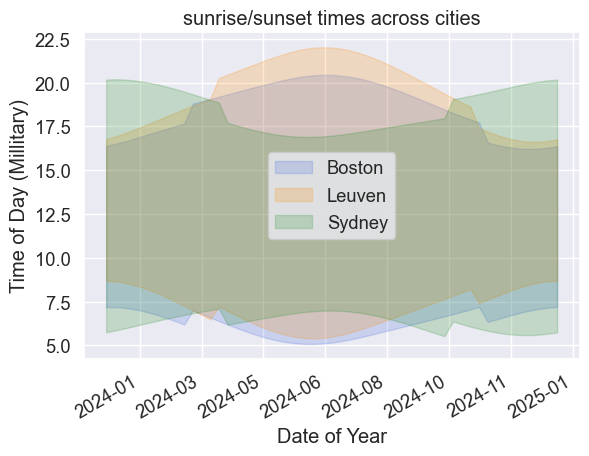

In [19]:

plot_daylight(df_annual_sun)